# import packages and get authenticated

In [1]:
# from google.colab import driveA
# drive.mount('drive')

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

# Plotting
# checklist 1: comment inline, uncomment Agg
%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import argparse
import os
import sys
sys.path.append('/content/drive/My Drive/中研院/repo/')
sys.path.append('~/project_FDDAT/repo/')
sys.path.append('../') # add this line so Data and data are visible in this file

from falldetect.utilities import *

import time
import datetime
from datetime import datetime

from sklearn.decomposition import PCA

from os.path import expanduser
home = expanduser("~")
# home_dir = home+'/project_FDDAT/'

# split_mode = 'LOO'
# split_mode = '5fold'

# Get user inputs
In ipython notebook, these are hardcoded. In production python code, use parsers to provide these inputs

In [3]:
parser = argparse.ArgumentParser(description='FD_DAT')
parser.add_argument('--dataset_name', metavar='dataset_name', help='dataset_name',
                    default='UMAFall')
parser.add_argument('--sensor_loc', metavar='sensor_loc', help='sensor_loc',
                    default='ankle')
parser.add_argument('--input_dir', metavar='input_dir', help='path to input_dir',
                    default='../')
parser.add_argument('--output_dir', metavar='output_dir', help='path to output_dir',
                    default='../')
parser.add_argument('--split_mode', metavar='split_mode', help='split_mode',
                    default='5fold')
parser.add_argument('--i_seed', type=int, metavar='i_seed', help='seed number',
                    default='0')
parser.add_argument('--excluded_idx', metavar='excluded_idx', 
                   default='none')
# split_mode = 'LOO'
# split_mode = '5fold'

# checklist 2: comment first line, uncomment second line seizures_FN
args = parser.parse_args(['--input_dir', '../../Data/{}/ImpactWindow_Resample_NormalforAllAxes/18hz/{}/',
                          '--output_dir', '../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_{}/{}/{}/', 
                          '--dataset_name', 'UMAFall', 
                          '--sensor_loc', 'wrist',
                          '--split_mode', '5fold',
                          '--i_seed', '1',
                          '--excluded_idx', '1 3 9 10 12 19',])
                          

# args = parser.parse_args()

In [4]:
input_dir = args.input_dir
output_dir = args.output_dir
dataset_name = args.dataset_name
sensor_loc = args.sensor_loc
home_dir = home+'/project_FDDAT/'
split_mode = args.split_mode
i_seed = args.i_seed
if args.excluded_idx == 'none':
    excluded_idx = []
else:
    excluded_idx = list(map(int, args.excluded_idx.split(' ')))

print(args)

Namespace(dataset_name='UMAFall', excluded_idx='1 3 9 10 12 19', i_seed=1, input_dir='../../Data/{}/ImpactWindow_Resample_NormalforAllAxes/18hz/{}/', output_dir='../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_{}/{}/{}/', sensor_loc='wrist', split_mode='5fold')


# load data_management (all) first

In [5]:
# dataset_name = 'UMAFall'
# # sensor_loc = 'waist'
# # sensor_loc = 'wrist'
# # sensor_loc = 'leg'
# # sensor_loc = 'chest'
# # sensor_loc = 'ankle'


# resampled, 18hz
DataNameList_inputdir = input_dir+'IP_{}_DataNameList_{}.csv'
DataNameList_inputdir = DataNameList_inputdir.format(dataset_name, sensor_loc, dataset_name, sensor_loc)

impact_inputdir = input_dir.format(dataset_name, sensor_loc)
outputdir = output_dir.format(split_mode, dataset_name, sensor_loc)

# DataNameList_inputdir = home_dir + 'Data/{}/ImpactWindow_Resample_NormalforAllAxes/18hz/{}/IP_{}_DataNameList_{}.csv'.format(dataset_name, sensor_loc, dataset_name, sensor_loc)
# impact_inputdir = home_dir + 'Data/{}/ImpactWindow_Resample_NormalforAllAxes/18hz/{}/'.format(dataset_name, sensor_loc)
# outputdir = home_dir + 'data_mic/stage1_preprocessed_18hz_{}/{}/{}/'.format(split_mode, dataset_name, sensor_loc)
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
print('will export data to', outputdir)

df = pd.read_csv(DataNameList_inputdir)
df.head(5)

will export data to ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UMAFall/wrist/


,x_DataName,Subject,Activity_ID,Trial,Position__0_leg_1_chest_2_waist_3_wrist_4_ankle_,FALL_1__ADL_0_
0,01_Aplausing_1_wrist_IP.csv,1,Aplausing,1,3,0
1,01_Aplausing_2_wrist_IP.csv,1,Aplausing,2,3,0
2,01_Aplausing_3_wrist_IP.csv,1,Aplausing,3,3,0
3,01_HandsUp_1_wrist_IP.csv,1,HandsUp,1,3,0
4,01_HandsUp_2_wrist_IP.csv,1,HandsUp,2,3,0


In [6]:
act_names = df['Activity_ID'].unique()
act_embeddings = { act_names[i] : i for i in range(0, act_names.shape[0] ) }
act_embeddings

{'Aplausing': 0,
 'HandsUp': 1,
 'MakingACall': 2,
 'OpeningDoor': 3,
 'Sitting': 4,
 'Walking': 5,
 'Bending': 6,
 'Hopping': 7,
 'Jogging': 8,
 'LyingDown': 9,
 'backwardFall': 10,
 'forwardFall': 11,
 'lateralFall': 12,
 'GoDownstairs': 13,
 'GoUpstairs': 14}

In [26]:
df[df['x_DataName']==filename].index[0]

590

In [7]:
temp = pd.read_csv(impact_inputdir+df['x_DataName'][0], header=None)

window_length = temp.shape[0]
samples_n = df.shape[0]

data_all = np.zeros((window_length,3,samples_n))
actlabels_all = np.zeros((samples_n,))
sub_all = np.zeros((samples_n,))
DataNameList_idx_all = np.zeros((samples_n,))

i = 0
for filename in tqdm(df['x_DataName']):
    sub_id = int(filename.split('_')[0])
#     activity_id = act_embeddings[filename.split('_')[1]]
    activity_id = df[df['x_DataName']==filename].FALL_1__ADL_0_.item()
    location = filename.split('_')[3][:-4]
    idx = df[df['x_DataName']==filename].index[0]
    
    df_imp = pd.read_csv(impact_inputdir+filename, header=None)

    data_all[:,:,i] = df_imp.to_numpy()
    actlabels_all[i] = activity_id
    sub_all[i] = sub_id
    DataNameList_idx_all[i] = idx
    i += 1

<ipython-input-7-f9eab654153d>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for filename in tqdm(df['x_DataName']):


In [8]:
# fall_n = (actlabels_all==10).sum()+(actlabels_all==11).sum()+(actlabels_all==12).sum()
fall_n = (actlabels_all==1).sum()
adl_n = data_all.shape[2]-fall_n
print('fall_n, adl_n:', fall_n, adl_n)

fall_n, adl_n: 198 393


In [9]:
np.where(actlabels_all==10)[0]

array([], dtype=int64)

In [10]:
samples_n = data_all.shape[2]
labels_n = np.shape(np.unique(actlabels_all))[0]
subjects_n = np.shape(np.unique(sub_all))[0]
print('finished reading data in data_management {} at {}'.format(dataset_name, sensor_loc))
print('Dimension of data', data_all.shape)
print('number of activities', labels_n)
print('number of subject', subjects_n)

finished reading data in data_management UMAFall at wrist
Dimension of data (66, 3, 591)
number of activities 2
number of subject 18


In [11]:
# sub_all.shape

In [12]:
# data_all.shape[2]

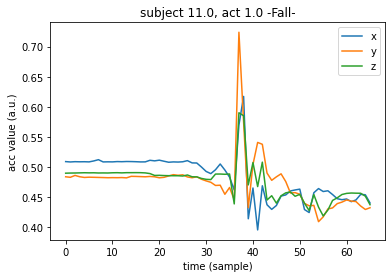

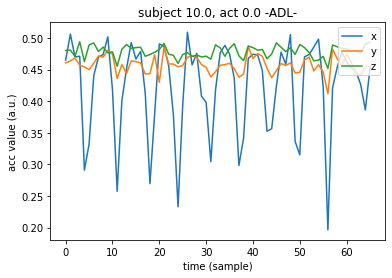

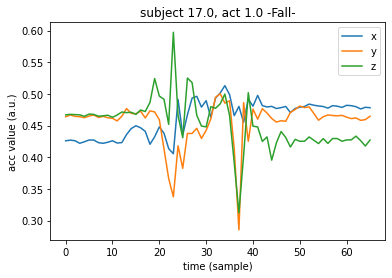

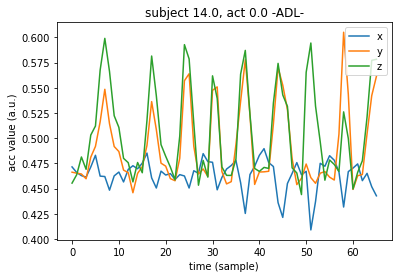

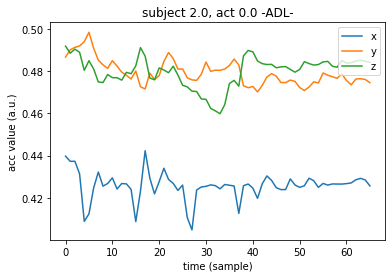

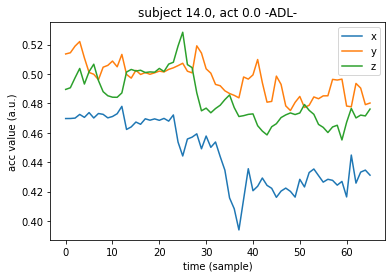

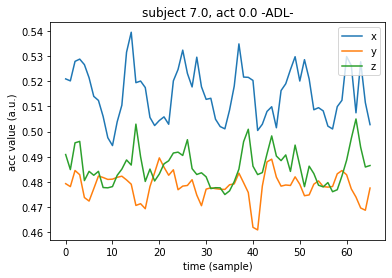

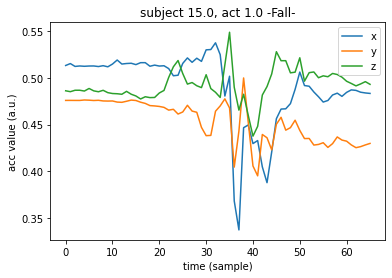

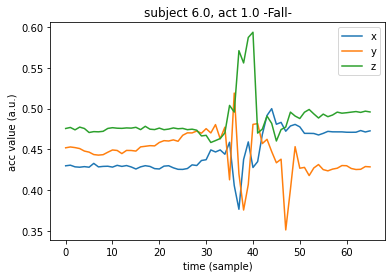

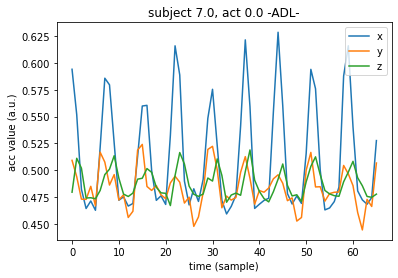

In [13]:
rand_idx = np.arange(data_all.shape[2])
np.random.shuffle(rand_idx)

for idx in range(10):
    i = rand_idx[idx]
#     if actlabels_all[i] < 10:
#         continue
    plt.plot(data_all[:,0,i], label='x')
    plt.plot(data_all[:,1,i], label='y')
    plt.plot(data_all[:,2,i], label='z')
    plt.ylabel('acc value (a.u.)')
    plt.xlabel('time (sample)')
    plt.legend(loc='upper right')
#     if actlabels_all[i] in [10,11,12]:
    if actlabels_all[i] == 1:
        plt.title('subject {}, act {} -Fall-'.format(sub_all[i], actlabels_all[i]))
    else:
        plt.title('subject {}, act {} -ADL-'.format(sub_all[i], actlabels_all[i]))

    plt.savefig(outputdir+'i{}_sample'.format(i))
    plt.show()

#     count += 1
#     if count == 10:
#         break

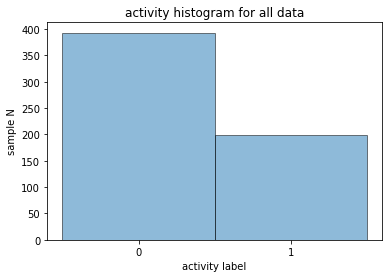

In [14]:
# ughhhhh  class 4, 9, 13, 14 are underrepresented
plt.hist(actlabels_all, bins=np.arange(labels_n+1)-0.5, alpha=0.5, histtype='bar', ec='black')
plt.xticks(range(labels_n))
plt.xlabel('activity label')
plt.ylabel('sample N')
plt.title('activity histogram for all data')
plt.savefig(outputdir+'act_hist')
plt.show()


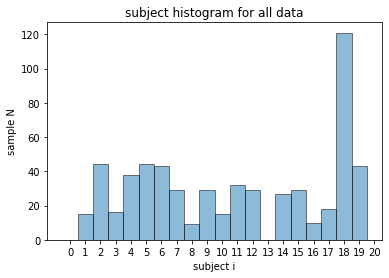

In [15]:
plt.hist(sub_all, bins=np.asarray(range(int(sub_all.max()+2)))-0.5, alpha=0.5, histtype='bar', ec='black')
plt.xticks(range(int(sub_all.max()+2)))
plt.xlabel('subject i')
plt.ylabel('sample N')
plt.title('subject histogram for all data')
plt.savefig(outputdir+'sub_hist')
plt.show()

# split data into train and val (1:1)
split by sample_id

In [16]:
i_sub_unique_all = np.unique(sub_all)
i_sub_excluded = []

if len(excluded_idx) == 0:
    for i_sub in i_sub_unique_all:
        idx_sub = np.where(sub_all==i_sub)[0]
#         idx_sub_fall = np.where((actlabels_all[idx_sub]==10) | (actlabels_all[idx_sub]==11) | (actlabels_all[idx_sub]==12))[0]
        idx_sub_fall = np.where(actlabels_all[idx_sub]==1)[0]

        if len(idx_sub_fall)==0:
            i_sub_excluded.append(int(i_sub))
else:
    i_sub_excluded = excluded_idx

print('i_sub {} has no fall data, will exclude'.format(i_sub_excluded))

i_sub_unique = np.array(list(set(i_sub_unique_all) - set(i_sub_excluded)))
print(i_sub_unique_all)
print(i_sub_excluded)
print(i_sub_unique)

if split_mode == 'LOO':
    CV_n = np.shape(i_sub_unique)[0]
elif split_mode == '5fold':
    CV_n = int(split_mode.split('fold')[0])
    
print('will split data into {} folds'.format(CV_n))

i_sub [1, 3, 9, 10, 12, 19] has no fall data, will exclude
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 14. 15. 16. 17. 18. 19.]
[1, 3, 9, 10, 12, 19]
[ 2.  4.  5.  6.  7.  8. 11. 14. 15. 16. 17. 18.]
will split data into 5 folds


In [17]:
from sklearn.model_selection import KFold
kfold = CV_n
kf = KFold(n_splits=kfold, shuffle=False)

i_sub_unique = np.array(list(set(i_sub_unique_all) - set(i_sub_excluded)))
print('all i_sub_unique', i_sub_unique)
np.random.seed(i_seed)
np.random.shuffle(i_sub_unique)
kf.get_n_splits(i_sub_unique)
print(kf)  

for train_index, val_index in kf.split(i_sub_unique):
    print("TRAIN:", i_sub_unique[train_index], "VAL:", i_sub_unique[val_index])

all i_sub_unique [ 2.  4.  5.  6.  7.  8. 11. 14. 15. 16. 17. 18.]
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [17.  4. 11.  2. 14. 18. 16. 15.  8.] VAL: [5. 6. 7.]
TRAIN: [ 5.  6.  7.  2. 14. 18. 16. 15.  8.] VAL: [17.  4. 11.]
TRAIN: [ 5.  6.  7. 17.  4. 11. 18. 16. 15.  8.] VAL: [ 2. 14.]
TRAIN: [ 5.  6.  7. 17.  4. 11.  2. 14. 15.  8.] VAL: [18. 16.]
TRAIN: [ 5.  6.  7. 17.  4. 11.  2. 14. 18. 16.] VAL: [15.  8.]


# Split based on CV results then 

In [18]:
i_CV = 0

for train_idx, val_idx in kf.split(i_sub_unique):
    print("Sub ID | TRAIN:", i_sub_unique[train_idx], "VAL:", i_sub_unique[val_idx])

    train_val_splitter(data_all, actlabels_all, sub_all, 
                       i_sub_unique[train_idx], i_sub_unique[val_idx], outputdir+'CV'+str(i_CV))

    i_CV = i_CV + 1


Sub ID | TRAIN: [17.  4. 11.  2. 14. 18. 16. 15.  8.] VAL: [5. 6. 7.]
train dimensions: (66, 3, 328) (328,) (328,)
val dimensions: (66, 3, 116) (116,) (116,)
outputdir for train: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UMAFall/wrist/CV0/train
outputdir for val: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UMAFall/wrist/CV0/val
outputdir for data: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UMAFall/wrist/CV0/train/data.npz
Are data save and loadded correctly?  True

outputdir for labels: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UMAFall/wrist/CV0/train/labels.npz
Are labels save and loadded correctly?  True

outputdir for i_sub: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UMAFall/wrist/CV0/train/i_sub.npz
Are i_sub save and loadded correctly?  True

outputdir for data: ../../data_mic/stage1_preprocessed_NormalforAllAxes_18hz_5fold/UMAFall/wrist/CV0/val/data.npz
Are data save and loadded c